
# Hand on machine learning
Today's lab will get you to run through all the steps necessary to build a machine learning classifier. This will involve each of the steps we covered in the previous session, namely:
1. Reading data
2. Pre-processing data
3. Building a neural network
4. Training a neural network
5. Evalauting a neural network

This notebook will likely also use some "magic" commands. These are commands that take advantage of jupyter's ability to run things other than python code (we will use some shell commands).


# Problem
MNIST is so 1998, we will instead classify CIFAR10 (plus it's Canadian, so clearly superier). 

In this lab we will use the [CIFAR10 dataset](http://www.cs.utoronto.ca/~kriz/cifar.html), which originates from Hinton's lab at university of Toronto. This dataset has very small natural images from 10 categories:

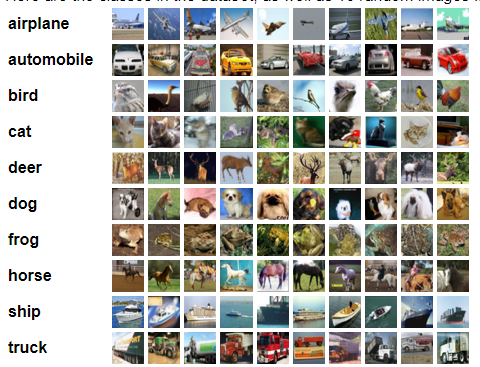


We're going to build a classifier to classify each images from each of these 10 categories. For fun we will also download some images to "test" on.

# Data Loading
CIFAR 10 is stored as a python `pickle` file. We can download it from the source website using `wget` as a magic command.

In [1]:
!wget http://www.cs.utoronto.ca/~kriz/cifar-10-python.tar.gz

--2020-09-14 03:14:44--  http://www.cs.utoronto.ca/~kriz/cifar-10-python.tar.gz
Resolving www.cs.utoronto.ca (www.cs.utoronto.ca)... 128.100.3.30
Connecting to www.cs.utoronto.ca (www.cs.utoronto.ca)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  47.5MB/s    in 3.6s    

2020-09-14 03:14:48 (45.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



From the filename we can tell that the data is compressed into a tarball, luckily this machine runs linux so we can easily decompress

In [2]:
!tar -zxvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


We can see that decompressed we have five data batches and a test batch. We'll leave the test batch for now, but we can load all of the data batches for training and validation

In [3]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

# we got this reference function from: http://www.cs.utoronto.ca/~kriz/cifar.html
def unpickle(file):
    with open(file, 'rb') as fp:
        data = pickle.load(fp, encoding='bytes')
    return data 

files = glob.glob('cifar-10-batches-py/data_batch_*')
print("All our file are now in this list: ", files)
batches = [unpickle(file) for file in files]

All our file are now in this list:  ['cifar-10-batches-py/data_batch_3', 'cifar-10-batches-py/data_batch_5', 'cifar-10-batches-py/data_batch_4', 'cifar-10-batches-py/data_batch_2', 'cifar-10-batches-py/data_batch_1']


Let's investigate what each of these files contain

In [4]:
sample_batch = batches[0]
type(sample_batch)

dict

In [5]:
sample_batch.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

We can see that each of the batches is a dictionary containing labels, data, and some other metadata (filenames, and the batch label).

What we will do for the purposes of this lab is take the first 4 batches and use it to create a "training set" and use the last batch as a "validation set". We use the validation set to measure how our model performs on data it hasn't been optimized for. This gives us an idea if it's overfitting or not. 

In [6]:
# as a background, from the webpage we already knew the datasize, but we could also quickly check:
sample_batch[b'data'].shape

(10000, 3072)

In [7]:
32*32*3

3072

In [8]:
# split the batches
train_batches, val_batches, test_batches = batches[:4]

# loading the data
train_images = np.concatenate([batch[b'data'] for batch in train_batches], axis=0)
train_labels = np.concatenate([batch[b'labels'] for batch in train_batches], axis=0)
val_images = np.concatenate([batch[b'data'] for batch in val_batches], axis=0)
val_labels = np.concatenate([batch[b'labels'] for batch in val_batches], axis=0)

# Pre-processing
Now that we have our data we want to verify that it is what we think (plotting and shape), then make it more suitable for machine learning

In [9]:
# checking the shape
train_images.shape

(40000, 3072)

In [10]:
#plt.imshow(train_x_data[0])

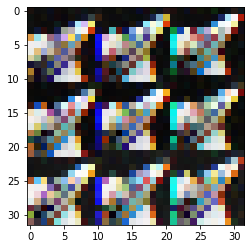

In [13]:
# also not correct!
plt.imshow(train_images[0].reshape(32, 32, 3))

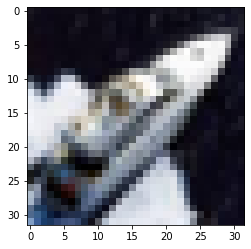

In [15]:
# better, move-axis will allow you to re-order your array
plt.imshow(np.moveaxis(train_images[0].reshape(3, 32, 32), [0, 1, 2], [2, 0, 1]))

We know from the source that this data is 8 bit uints, but we could also check

In [16]:
train_images.dtype

dtype('uint8')

In [17]:
# notice how we have an extra dimension! From the batch label
train_x_data = np.moveaxis(train_images.reshape(-1, 3, 32, 32), [0, 1, 2, 3], [0, 3, 1, 2])
val_x_data = np.moveaxis(val_images.reshape(-1, 3, 32, 32), [0, 1, 2, 3], [0, 3, 1, 2])
# pre-processing to zero center the data
train_x_data = (train_x_data.astype(np.float32)/255.0) - 0.5
val_x_data = (val_x_data.astype(np.float32)/255.0) - 0.5
# we will also turn our labels into one-hot targets
train_y_data = np.eye(10)[train_labels]
val_y_data = np.eye(10)[val_labels]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


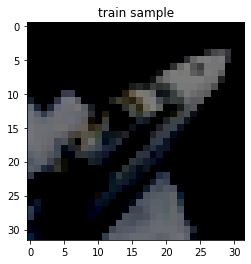

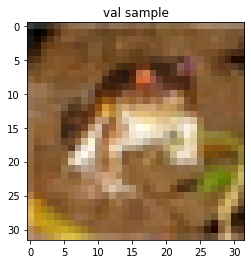

In [18]:
# validate one more time....
plt.figure()
plt.title("train sample")
plt.imshow(train_x_data[0])
plt.figure()
plt.title("val sample")
plt.imshow(val_x_data[0] + 0.5)

# Model Building

In the previous lab we downloaded a pre-built model,  specifically ResNet50. In this lab I'll show you how to build a very simple one on your own, although we could use a more complex model it will take longer to train and be less instructive. For performance sensitive applications it's important to try many different models

In [19]:
import tensorflow as tf
def gen_model(input_size, classes):
    input_layer = tf.keras.layers.Input(shape=input_size)
    
    x = tf.keras.layers.Conv2D(8, 3, activation='relu')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
    
    x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2)(x)

    # x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    # x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    # x = tf.keras.layers.MaxPool2D(2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(classes, activation='softmax')(x)

    full_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return full_model

In [20]:
model = gen_model((32, 32, 3), 10)

In [21]:
# we can get a quick summary of our model using `.summary()`
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)         

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
batch_size = 16
model.fit(train_x_data, train_y_data, batch_size=batch_size, epochs=5, validation_data=(val_x_data, val_y_data))

Epoch 1/5
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8002 - acc: 0.7141 - val_loss: 0.9881 - val_acc: 0.6526
Epoch 2/5
2500/2500 [==============================] - 9s 4ms/step - loss: 0.7363 - acc: 0.7349 - val_loss: 0.9642 - val_acc: 0.6724
Epoch 3/5
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6771 - acc: 0.7595 - val_loss: 0.9551 - val_acc: 0.6783
Epoch 4/5
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6293 - acc: 0.7745 - val_loss: 0.9900 - val_acc: 0.6787
Epoch 5/5
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5763 - acc: 0.7944 - val_loss: 0.9990 - val_acc: 0.6821


# Exercises
You may find last labs slides useful: https://deepimaging.github.io/tasess/ml_pipeline_F20.pdf


**Evaluation**
1. Add evaluation code that uses the "test_batch" data we downloaded
2. Run the evaluation step
3. Compare performance to the validation set

**CIFAR-100**
1. Modify the existing code to use CIFAR-100 instead of CIFAR-10:
    * https://www.cs.toronto.edu/~kriz/cifar.html
    * https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
2. See how the number of epochs you train for effects performance
3. Try changing the model out:
    * Either modify the existing model
    * Or use a pre-built model (for example ResNet50)


